In [1]:
import sys
import os
sys.path.append('..')
import src.svm_utils as svm_utils
import src.visualization_utils as viz_utils
import src.ds_utils as ds_utils
import torch
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import src.pytorch_datasets as pytorch_datasets
import tqdm


sns.set()

In [2]:
sns.set()
BLUE = sns.color_palette("tab10")[0]
RED = sns.color_palette("tab10")[3]
ORANGE = sns.color_palette("tab10")[1]
BROWN = sns.color_palette("tab10")[5]
GRAY = sns.color_palette("tab10")[7]
GREEN = sns.color_palette("tab10")[2]

import matplotlib.pylab as pylab
params = {'legend.fontsize': 12,
          'figure.figsize': (5, 3),
         'axes.labelsize': 14,
         'axes.titlesize':16,
         'xtick.labelsize':14,
         'ytick.labelsize':14}
pylab.rcParams.update(params)


In [3]:
DS_ROOT = "/mnt/nfs/datasets/ChestX-ray14"
test_ds = pytorch_datasets.ChestXrayDataSet('test', DS_ROOT)
annot_name = os.path.join(DS_ROOT, "chestxray_metadata_2017_v2020.csv")
annotations = pd.read_csv(annot_name)
test_image_names = [os.path.basename(u) for u in  test_ds.image_names]

big_index = annotations['Image Index'].to_numpy()
test_subset = []
for u in tqdm.tqdm(test_image_names):
    test_subset.append(np.where(big_index == u)[0][0])
test_annotations = annotations.loc[test_subset].reset_index()

100%|██████████| 22433/22433 [02:46<00:00, 134.89it/s]


In [5]:
beton_root = "/mnt/cfs/projects/correlated_errors/betons"
experiment_root = "/mnt/cfs/projects/correlated_errors/experiments/chestxray/"
condition = 3 # 2

primary_condition ={
    2: 'Effusion',
    3: 'Infiltration',
    4: 'Mass',
}[condition]

name = os.path.join(experiment_root, f"svm_checkpoints/chestxray_svm_{condition}.pt") # SVM output file
model_root = os.path.join(experiment_root, "models")
model_ckpt = os.path.join(model_root, "vanilla_chestxray/version_3/checkpoints/checkpoint_last.pt")
loss_upweight_root = os.path.join(experiment_root, "loss_vec_files")
subset_root = os.path.join(experiment_root, "subset_index_files")



In [6]:
processor = viz_utils.SVMProcessor(name, root=beton_root, checkpoint_path=model_ckpt)

-----------val_metrics--------------
{'Confusion Matrix': array([[2771,  463],
       [1255, 6730]]),
 'Model Accuracy': 0.7117390141723862,
 'SVM Accuracy': 0.8468669056892395,
 'SVM Balanced Accuracy': 0.8498319685459137}
-----------train_metrics--------------
{'Confusion Matrix': array([[16456,  4097],
       [10919, 46996]]),
 'Model Accuracy': 0.7380715705765407,
 'SVM Accuracy': 0.8086353540420532,
 'SVM Balanced Accuracy': 0.8060633838176727}
-----------test_metrics--------------
{'Confusion Matrix': array([[ 5041,  1349],
       [ 2843, 13200]]),
 'Model Accuracy': 0.7151517853162751,
 'SVM Accuracy': 0.8131324648857117,
 'SVM Balanced Accuracy': 0.8058388233184814}
Using default os_cache: False
Using default quasi_random: True
Using default val_aug: None
Using default loss_vec_file: None
Using default indices_file: None
Using default unlabeled_beton: None
Using default loss_upweight: 5
Using default cmnist: False

-----------CONFIG--------------
{   'arch': 'resnet18',
    'ar

100%|██████████| 785/785 [02:01<00:00,  6.46it/s]


Accuracy 0.7393077611923218


100%|██████████| 113/113 [00:21<00:00,  5.20it/s]


Accuracy 0.7117390036582947


100%|██████████| 225/225 [00:38<00:00,  5.84it/s]


Accuracy 0.7151517868041992


In [51]:
def get_secondary_conditions(findings_list):
    secondary_conditions = []
    for u in test_findings:
        secondary_condition = False
        for u2 in u:
            if u2 == "No Finding" or u2 == primary_condition:
                continue
            else:                    
                secondary_condition = True
        secondary_conditions.append(secondary_condition)
    secondary_conditions = np.array(secondary_conditions)
    return secondary_conditions

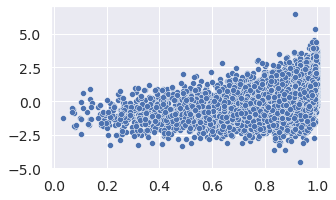

---- CONFIDENCE ------


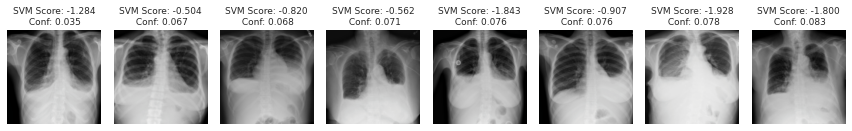

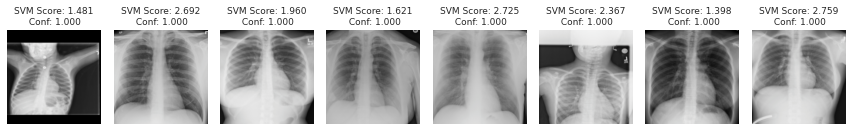

---- SVM ------


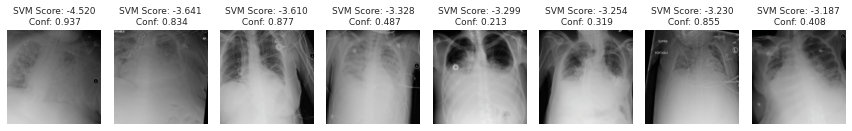

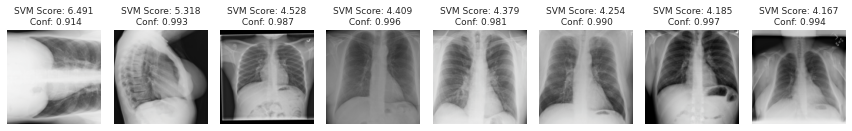

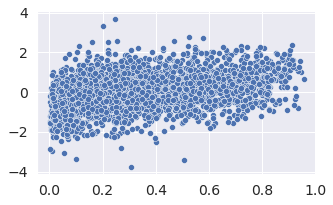

---- CONFIDENCE ------


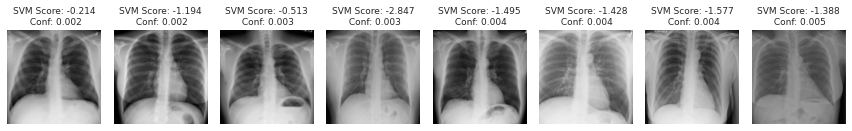

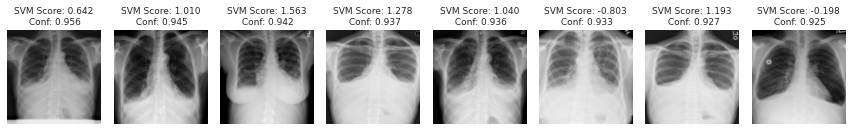

---- SVM ------


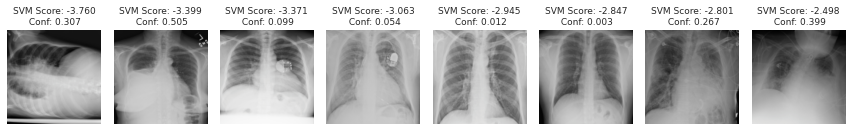

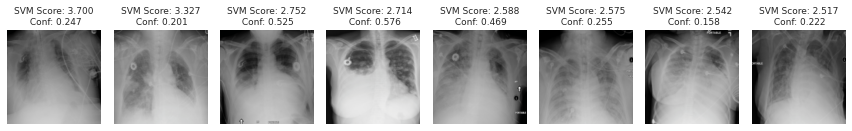

In [52]:
# display extremes for original model
os.makedirs('figures/chestxray', exist_ok=True)
for c in range(2):
    processor.display_extremes(c, split='test', rows=1, columns=8, filename=f'figures/chestxray/{primary_condition}_{c}_extremes')

In [53]:
split = 'test'
test_dv = processor.metrics[f'{split}_metrics']['decision_values']
test_confs = processor.run_dict[split]['confs']
test_class = processor.metrics[f'{split}_metrics']['classes'] # 0 if female, 1 if male
test_pred_correct = processor.metrics[f'{split}_metrics']['ypred']
test_correct = processor.metrics[f'{split}_metrics']['ytrue']
test_findings = [u.split('|') for u in tqdm.tqdm(test_annotations['Finding Labels'].to_numpy())]
test_healthy = test_annotations['Finding Labels'] == 'No Finding'
test_secondary_conditions = get_secondary_conditions(test_findings)
test_male = (test_annotations['Patient Gender'] == 'M').to_numpy()
test_PA = (test_annotations['View Position'] == 'PA').to_numpy()

100%|██████████| 22433/22433 [00:00<00:00, 1956719.66it/s]


In [54]:
import sklearn.metrics as sklearn_metrics
import seaborn as sns
import matplotlib.pyplot as plt
def print_confusion_matrices(test_problematic, condition_name, class_mask=None, filename=None):
    if class_mask is None:
        class_mask = np.ones(len(test_problematic)).astype(bool)
        
    problematic = test_problematic[class_mask]
    correct = test_correct[class_mask]
    pred_correct = test_pred_correct[class_mask]
    dv_order = np.argsort(test_dv[class_mask])
    conf_order = np.argsort(test_confs[class_mask])
    
    print(f"Percentage that is {condition_name}: {problematic.mean():0.2%}")
    print(f"Percentage that is incorrect: {(correct==0).mean():0.2%}")
    print(f"Percentage that is flagged: {(pred_correct==0).mean():0.2%}")
    print("--")
    
    fig, ax_ = plt.subplots(1, 2, figsize=(12, 4))

    ax = ax_[0]
    conf_matrix = sklearn_metrics.confusion_matrix(y_true=(problematic == 0), y_pred=correct)
    sns.heatmap(conf_matrix/conf_matrix.sum(), fmt='.2%', annot=True, cmap='Blues', ax=ax)
    ax.yaxis.set_ticklabels([f'{condition_name}', f'Not {condition_name}'])
    ax.xaxis.set_ticklabels(['Incorrect', 'Correct'])
    perc_incorr_that_is_prob = (problematic & (correct == 0)).sum()/(correct == 0).sum()
    perc_prob_that_is_incorr = (problematic & (correct == 0)).sum()/(problematic).sum()
    print(f"percentage incorrect that is {condition_name} {perc_incorr_that_is_prob:0.3%}")
    print(f"percentage {condition_name} that is incorrect {perc_prob_that_is_incorr:0.3%}")

    print("-")
    conf_matrix = sklearn_metrics.confusion_matrix(y_true=(problematic == 0), y_pred=pred_correct)
    ax = ax_[1]
    sns.heatmap(conf_matrix/conf_matrix.sum(), fmt='.2%', annot=True, cmap='Blues', ax=ax)
    ax.yaxis.set_ticklabels([f'{condition_name}', f'Not {condition_name}'])
    ax.xaxis.set_ticklabels(['Predicted Incorrect', 'Predicted Correct'])
    perc_incorr_that_is_prob = (problematic & (pred_correct == 0)).sum()/(pred_correct == 0).sum()
    perc_prob_that_is_incorr = (problematic & (pred_correct == 0)).sum()/(problematic).sum()
    print(f"percentage flagged that is {condition_name} {perc_incorr_that_is_prob:0.3%}")
    print(f"percentage {condition_name} that is flagged {perc_prob_that_is_incorr:0.3%}")
    plt.show()
    
    K_range = np.arange(10, len(problematic), 10) 
    df = []
    def compute_fraction(arr):
        return arr.sum()/len(arr)
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    for K in K_range:
        df.append([
            K,
            compute_fraction(problematic[dv_order[:K]]),
            compute_fraction(problematic[conf_order[:K]]),
            compute_fraction(problematic),
        ])
    df = pd.DataFrame(df, columns=['Top K', 'SVM Decision Value', 'Confidence', 'Base Population'])
    df = df.melt(['Top K'], var_name='Order', value_name=f'Fraction {condition_name}')
    sns.lineplot(data=df, x='Top K', y=f'Fraction {condition_name}', hue='Order', ax=ax,
                 hue_order=['SVM Decision Value', 'Confidence', 'Base Population'],
                 palette=[BLUE, RED, GRAY]
                )
    ax.set_xlabel("Top K Flagged")
    
#     handles, labels = ax.get_legend_handles_labels()
#     ax.legend(handles=handles, labels=labels)
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')
        
    plt.show()

------------------------ All ------------------------
Percentage that is AP: 39.44%
Percentage that is incorrect: 12.62%
Percentage that is flagged: 28.11%
--
percentage incorrect that is AP 55.351%
percentage AP that is incorrect 17.712%
-
percentage flagged that is AP 59.826%
percentage AP that is flagged 42.636%


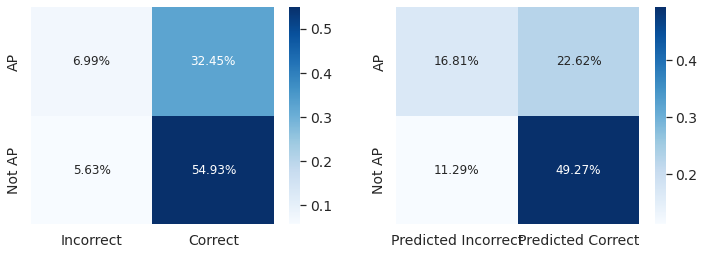

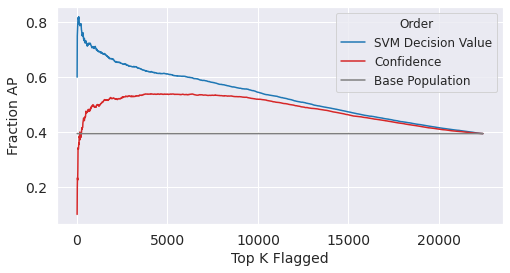

------------------------ No Effusion ------------------------
Percentage that is AP: 38.18%
Percentage that is incorrect: 7.02%
Percentage that is flagged: 25.51%
--
percentage incorrect that is AP 57.567%
percentage AP that is incorrect 10.582%
-
percentage flagged that is AP 63.645%
percentage AP that is flagged 42.526%


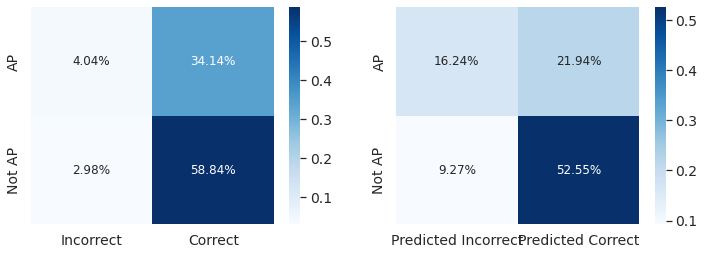

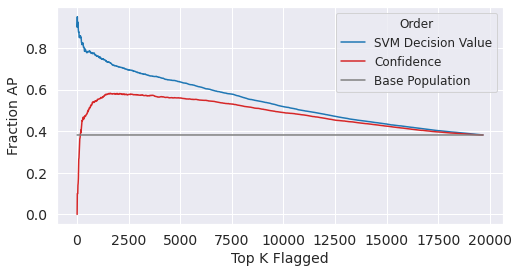

------------------------ Effusion ------------------------
Percentage that is AP: 48.44%
Percentage that is incorrect: 52.65%
Percentage that is flagged: 46.66%
--
percentage incorrect that is AP 53.241%
percentage AP that is incorrect 57.871%
-
percentage flagged that is AP 44.903%
percentage AP that is flagged 43.253%


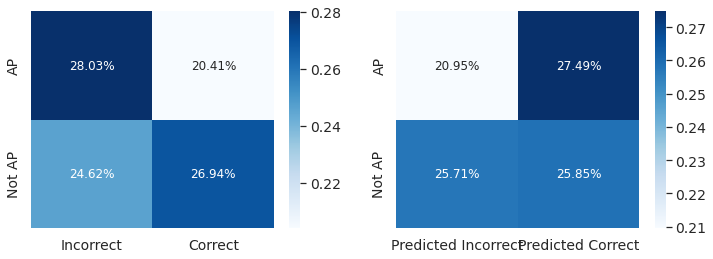

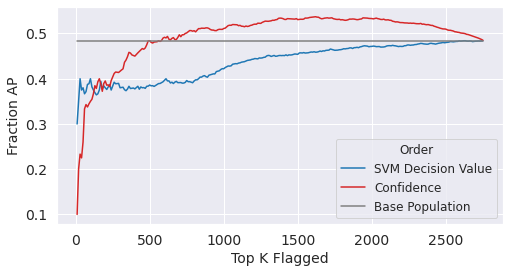

In [55]:
for class_mask, name in [
    (None, f"All"),
    (test_class==0, f"No {primary_condition}"), 
    (test_class==1, f"{primary_condition}")]:
    print("------------------------", name, "------------------------")
    print_confusion_matrices(~test_PA, "AP", class_mask=class_mask, filename=f"figures/chestxray/{primary_condition}_AP_{name}.pdf")
#     print_confusion_matrices(test_secondary_conditions, "sec. cond.", class_mask=class_mask)
#     print_confusion_matrices(~test_male, "female", class_mask=class_mask)